In [72]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [73]:
!pip install xmltodict

In [74]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
import os

from PIL import Image

import torch
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader
from PIL import Image


import torch.optim as optim

import xmltodict
import cv2
import torch.nn.functional as F

In [75]:
# Load your dataset and annotations
img_names=[] 
xml_names=[] 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]!="xml":
            img_names.append(filename)
        else:
            xml_names.append(filename)

In [76]:
path_annotations="/kaggle/input/face-mask-detection/annotations/" 
listing=[]
for i in img_names[:]:
    with open(path_annotations+i[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            listing.append(temp[i]["name"])
    else:
        listing.append(temp["name"])

In [77]:
Items = Counter(listing).keys()
values = Counter(listing).values()
print(Items,'\n',values)

dict_keys(['with_mask', 'mask_weared_incorrect', 'without_mask']) 
 dict_values([3232, 123, 717])


In [78]:
path_image="/kaggle/input/face-mask-detection/images/"  
def face_cas(img): 
    with open(path_annotations+img[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    image=plt.imread(os.path.join(path_image+img))
    fig,ax=plt.subplots(1)
    ax.axis("off")
    fig.set_size_inches(10,5)
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            ###with_mask
            if temp[i]["name"]=="with_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='g',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("with_mask", (rx, ry), color='green', weight='bold', fontsize=10, ha='left', va='baseline')
            ###without_mask
            if temp[i]["name"]=="without_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))     
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='r',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("without_mask", (rx, ry), color='red', weight='bold', fontsize=10, ha='left', va='baseline')
            ###mask_weared_incorrect
            if temp[i]["name"]=="mask_weared_incorrect":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='y',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("mask_weared_incorrect", (rx, ry), color='yellow', weight='bold', fontsize=10, ha='left', va='baseline')
    else:
        x,y,w,h=list(map(int,temp["bndbox"].values()))
        edgecolor={"with_mask":"g","without_mask":"r","mask_weared_incorrect":"y"}
        mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor=edgecolor[temp["name"]],facecolor="none",)
    ax.imshow(image)
    ax.add_patch(mpatch)

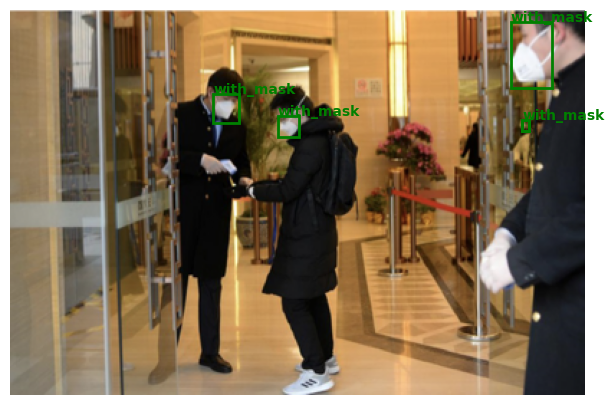

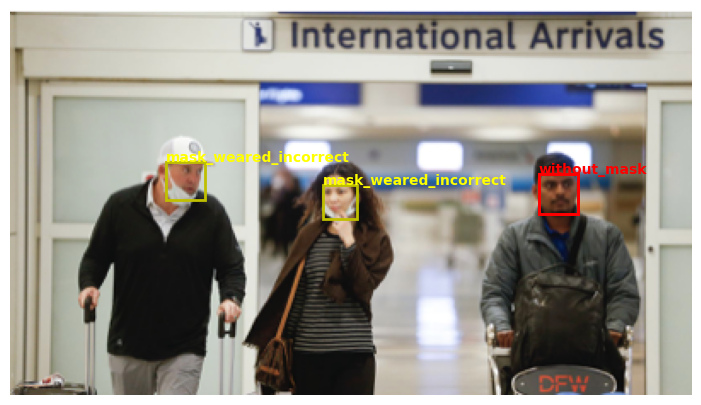

In [79]:
fun_images = img_names.copy()
for i in range(1,3):
    face_cas(fun_images[i])

In [80]:
options={"with_mask":0,"without_mask":1,"mask_weared_incorrect":2} 
def dataset_creation(image_list): 
    image_tensor=[]
    label_tensor=[]
    for i,j in enumerate(image_list):
        with open(path_annotations+j[:-4]+".xml") as fd:
            doc=xmltodict.parse(fd.read())
        if type(doc["annotation"]["object"])!=list:
            temp=doc["annotation"]["object"]
            x,y,w,h=list(map(int,temp["bndbox"].values()))
            label=options[temp["name"]]
            image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"), y,x,h-y,w-x)
            image_tensor.append(my_transform(image))
            label_tensor.append(torch.tensor(label))
        else:
            temp=doc["annotation"]["object"]
            for k in range(len(temp)):
                x,y,w,h=list(map(int,temp[k]["bndbox"].values()))
                label=options[temp[k]["name"]]
                image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"),y,x,h-y,w-x)
                image_tensor.append(my_transform(image))
                label_tensor.append(torch.tensor(label))
                
    final_dataset=[[k,l] for k,l in zip(image_tensor,label_tensor)]
    return tuple(final_dataset)

In [81]:
my_transform=transforms.Compose([transforms.Resize((226,226)),
                                 transforms.ToTensor()])

mydataset=dataset_creation(img_names)

train_size=int(len(mydataset)*0.7)
test_size=len(mydataset)-train_size

In [82]:
trainset,testset=torch.utils.data.random_split(mydataset,[train_size,test_size])

train_dataloader =DataLoader(dataset=trainset,batch_size=32,shuffle=True,num_workers=4)
test_dataloader =DataLoader(dataset=testset,batch_size=32,shuffle=True,num_workers=4)

In [83]:
device = torch.device("cuda:0" if torch.cuda.is_available()
                               else "cpu")

In [84]:
import sys
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 226, 226])
Labels batch shape: torch.Size([32])


In [85]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

train_features_np=train_features.numpy()

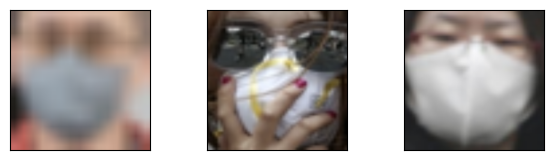

In [86]:
fig=plt.figure(figsize=(25,4))
for idx in np.arange(3):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    plt.imshow(np.transpose(train_features_np[idx],(1,2,0)))
    

In [87]:
model=models.resnet34(pretrained=True)
for param in model.parameters():
    param.requires_grad=False

In [88]:
import torch.nn as nn
n_inputs=model.fc.in_features
last_layer=nn.Linear(n_inputs,3)

In [89]:
model.fc = last_layer
print('reinitialize model with output features as 3 :', model.fc)

reinitialize model with output features as 3 : Linear(in_features=512, out_features=3, bias=True)


In [90]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

In [91]:
model= model.to(device)

In [92]:
for epoch in range(1, 20):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 20 == 19:
            print("Epoch {}, batch {}, training loss {}".format(epoch, i+1, running_loss/20))
            running_loss = 0.0

print('\nFinished Training')

Epoch 1, batch 20, training loss 0.6772502467036248
Epoch 1, batch 40, training loss 0.5587745204567909
Epoch 1, batch 60, training loss 0.4084022559225559
Epoch 1, batch 80, training loss 0.4083909809589386
Epoch 2, batch 20, training loss 0.4215892665088177
Epoch 2, batch 40, training loss 0.3535977631807327
Epoch 2, batch 60, training loss 0.3318513069301844
Epoch 2, batch 80, training loss 0.33538593500852587
Epoch 3, batch 20, training loss 0.33644199594855306
Epoch 3, batch 40, training loss 0.3249227948486805
Epoch 3, batch 60, training loss 0.3059837270528078
Epoch 3, batch 80, training loss 0.22520042657852174
Epoch 4, batch 20, training loss 0.27512658685445784
Epoch 4, batch 40, training loss 0.26330316439270973
Epoch 4, batch 60, training loss 0.29010535553097727
Epoch 4, batch 80, training loss 0.2726835131645203
Epoch 5, batch 20, training loss 0.3228907998651266
Epoch 5, batch 40, training loss 0.2939767181873322
Epoch 5, batch 60, training loss 0.2480748888105154
Epoch 

In [93]:
model_save_path = "/kaggle/working/model.pth"
torch.save(model.state_dict(), model_save_path)

In [94]:
# Load the saved model
model_load_path = "/kaggle/working/model.pth"
model = models.resnet34(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
n_inputs = model.fc.in_features
last_layer = nn.Linear(n_inputs, 3)
model.fc = last_layer  # Replace the whole fc layer instead of assigning to out_features
model.load_state_dict(torch.load(model_load_path), strict=False)  # Set strict=False to skip loading last_layer weights and biases
print("Model loaded from:", model_load_path)

Model loaded from: /kaggle/working/model.pth


In [112]:
model.eval()
model = model.to(device)


total_correct = 0
total_samples = 0


correct_images = []
incorrect_images = []


for inputs, labels in test_dataloader:
    inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model


    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

    total_correct += (predicted == labels).sum().item()
    total_samples += labels.size(0)

    for i in range(len(inputs)):
        image = inputs[i].cpu().numpy().transpose(1, 2, 0)  # Move the image to the CPU and change the channel order
        label_name = list(options.keys())[list(options.values()).index(labels[i].item())]
        prediction_name = list(options.keys())[list(options.values()).index(predicted[i].item())]

        if label_name == prediction_name:
            correct_images.append((image, label_name))
        else:
            incorrect_images.append((image, label_name, prediction_name))

accuracy = total_correct / total_samples
print("Accuracy on test samples: {:.2f}%".format(accuracy * 100))

Accuracy on test samples: 92.64%


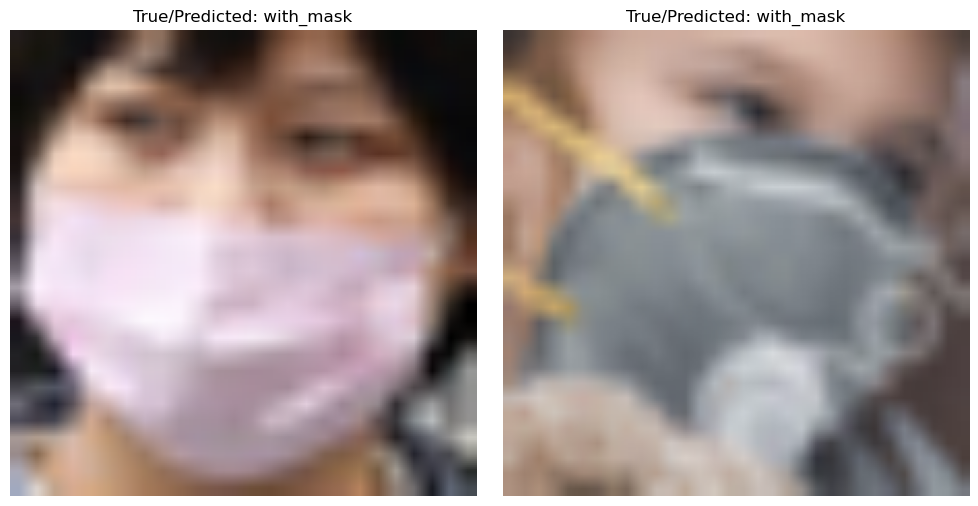

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, (image, label_name) in enumerate(correct_images[:2]):
    axes[i].imshow(image)
    axes[i].set_title(f"True/Predicted: {label_name}", fontsize=12)
    axes[i].axis("off")
plt.tight_layout()
plt.show()

In [115]:
def real_time_face_mask_detection(model, labels):

    cap = cv2.VideoCapture(0)

    while True:

        ret, frame = cap.read()
        if not ret:
            break


        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        image = my_transform(image)
        image = image.unsqueeze(0)


        model.eval()
        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)
            prediction = labels[predicted.item()]


        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.8
        thickness = 2
        text = f"Prediction: {prediction}"
        text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
        text_x = frame.shape[1] - text_size[0] - 10
        text_y = text_size[1] + 10
        cv2.putText(frame, text, (text_x, text_y), font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)


        cv2.imshow("Face Mask Detection", frame)


        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release webcam and close all windows
    cap.release()
    cv2.destroyAllWindows()